In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.fastai.conv_learner import *

In [3]:
PATH = "data/mnist/"

In [4]:
!ls {PATH}

mnist.pkl.gz models       test.csv     tmp          train.csv


## Data Prep

In [5]:
train = pd.read_csv(f'{PATH}train.csv')
# test = pd.read_csv(f'{PATH}test.csv')

In [6]:
# split apart the labels
y, x = np.split(train, [1], axis=1)

In [7]:
# need a np.array rather than pd.dataframe
x = x.as_matrix()
type(x), x.shape

(numpy.ndarray, (42000, 784))

In [8]:
# Use this for the CNN below
x = np.reshape(x, (-1, 28, 28)); x.shape

(42000, 28, 28)

In [8]:
# convert labels to ndarray  (NEED THIS TO BE 0 dimension)
y = np.array(y['label'].tolist())
type(y), y.shape

(numpy.ndarray, (42000,))

In [78]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [79]:
# need a 28x28 matrix
imgs = np.reshape(x, (-1,28,28)); imgs.shape

(42000, 28, 28)

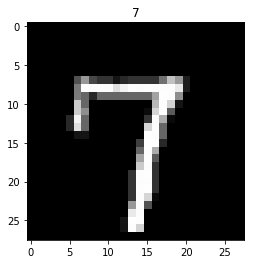

In [80]:
show(imgs[6], y[6])

In [9]:
# normalize data  (x - mean)/std
# mean = 0, std = 1
mean = x.mean()
std = x.std()

x = (x - mean)/std

mean, std, x.mean(), x.std()

(33.408911169825075,
 78.677739760763586,
 -2.7735507444338314e-17,
 0.99999999999999989)

In [10]:
# split off validation set
x_val = x[32000:]
x_trn = x[:32000]

y_val = y[32000:]
y_trn = y[:32000]

x_val.shape, x_trn.shape, y_val.shape, y_trn.shape

((10000, 784), (32000, 784), (10000,), (32000,))

## Set up generator - data loader

In [11]:
md = ImageClassifierData.from_arrays(PATH, trn=(x_trn,y_trn), val=(x_val,y_val))

In [12]:
dl = iter(md.trn_dl)
xmb,ymb = next(dl)

In [13]:
xmb.shape,ymb.shape

(torch.Size([64, 784]), torch.Size([64]))

## Logistic Regression - single linear layer   [0.3156971, 0.91013136942675155]

In [86]:
net = nn.Sequential(
    nn.Linear(784, 10),
    nn.LogSoftmax()
) 

In [88]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net.parameters())

In [89]:
fit(net, md, 1, opt=opt, crit=loss, metrics=metrics)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.335152   0.315697   0.910131  



[0.3156971, 0.91013136942675155]

### expanded version

In [138]:
def norm_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])

def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        # self.linear = nn.Linear(28*28,10)
        self.l1_w = norm_weights(784,10)
        self.l1_b = norm_weights(10)
        
    def forward(self,x):
        # 64x28x28 tensor returned, need a matrix
        x = x.view(x.size(0), -1)
        
        #pred = self.linear(x)  =>  y = wx + b
        pred = (x @ self.l1_w) + self.l1_b
        
        return torch.log(softmax(pred))

In [139]:
net = LogReg()
opt=optim.Adam(net.parameters())

In [140]:
fit(net, md, 1, opt=opt, crit=loss, metrics=metrics)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.319462   0.310924   0.911226  



[0.31092447, 0.91122611464968151]

### explicit training loop

In [141]:
def score(x, y):
    y_pred = to_np(net(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [142]:
for epoch in range(1):
    losses = []
    dl = iter(md.trn_dl)
    for t in range(len(dl)):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        pred = net(V(xt))
        l = loss(pred, V(yt))
        losses.append(l)
        
        # Backward pass:
        opt.zero_grad()  # zero gradients
        l.backward()     # calc gradient of the loss (autograd)
        
        opt.step()       # updates weights/biases with gradients

        # Alternative to using the optimizer => SGD w/ learning rate
        # w.data -= w.grad.data * lr
        # b.data -= b.grad.data * lr
        # w.grad.data.zero_()
        # b.grad.data.zero_()   
        
    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    print(np.mean(val_scores))

0.91590366242


## Deep Neural Network  [0.12243996, 0.96178343949044587]

In [143]:
net = nn.Sequential(
    nn.Linear(28*28, 1000),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)

In [14]:
net = nn.Sequential(
    nn.Linear(28*28, 1000),
    nn.Sigmoid(),
    nn.Linear(1000, 10),
    nn.LogSoftmax()
)

# [0.20624673, 0.93879378980891715]

In [15]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net.parameters())

In [145]:
fit(net, md, 1, opt=opt, crit=loss, metrics=metrics)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                    
    0      0.139675   0.12244    0.961783  



[0.12243996, 0.96178343949044587]

## Convolutional Neural Network

- Reload data and reshape into 3d array (n, h, w)

- Need to modify the data loader to output a 4d tensor (including channel dimension)  

**(batch size, channels, height, width)**

In [18]:
x_trn.shape, y_trn.shape

((32000, 28, 28), (32000,))

In [17]:
x_trn_3d = np.expand_dims(x_trn, 1)
x_val_3d = np.expand_dims(x_val, 1)
x_trn_3d.shape, x_val_3d.shape

((32000, 1, 28, 28), (10000, 1, 28, 28))

In [19]:
md = ImageClassifierData.from_arrays(PATH, trn=(x_trn_3d,y_trn), val=(x_val_3d,y_val))

In [20]:
dl = iter(md.trn_dl)
xmb,ymb = next(dl)

In [21]:
xmb.shape,ymb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [36]:
net = nn.Sequential(
    # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
    nn.Conv2d(1,16,5), #=> output size: 24x24
    nn.ReLU(),
    nn.Conv2d(16, 32, 5), #=> 20x20
    nn.ReLU(),
    nn.Conv2d(32, 64, 5), #=> 16x16
    nn.ReLU(),
    # nn.AdaptiveMaxPool2d(1),
    nn.Conv2d(64, 10, 1), #=> 16x16
    nn.LogSoftmax()
)

In [74]:
net = nn.Sequential(
    nn.Conv2d(1, 32, 5, 1, 1),
    nn.MaxPool2d(2, 2),
    nn.ReLU(True),
    nn.BatchNorm2d(32),

    nn.Conv2d(32, 64, 3,  1, 1),
    nn.ReLU(True),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 64, 3,  1, 1),
    nn.MaxPool2d(2, 2),
    nn.ReLU(True),
    nn.BatchNorm2d(64),

    nn.Conv2d(64, 128, 3, 1, 1),
    nn.ReLU(True),
    nn.BatchNorm2d(128),
    
    nn.Conv2d(128, 10, 1)
)

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()

In [94]:
class mnist_model(nn.Module):

    def __init__(self):
        super(mnist_model, self).__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, 3,  1, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, 3,  1, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(True),
            nn.BatchNorm2d(128)
        )

        self.classifier = nn.Conv2d(128, 10, 1)
        self.avgpool = nn.AvgPool2d(6, 6)
        self.dropout = nn.Dropout(0.5)

    def forward(self, inputs):
        out = self.feats(inputs)
        out = self.dropout(out)
        out = self.classifier(out)
        out = self.avgpool(out)
        out = out.view(-1, 10)
        return out
    
net = mnist_model()

In [92]:
loss=nn.NLLLoss()
metrics=[accuracy]
opt=optim.Adam(net.parameters())

In [93]:
fit(net, md, 3, opt=opt, crit=loss, metrics=metrics)

A Jupyter Widget

  0%|          | 0/500 [00:00<?, ?it/s]<class 'torch.autograd.variable.Variable'>



RuntimeError: Expected object of type Variable[torch.FloatTensor] but found type Variable[torch.LongTensor] for argument #1 'target'